<a href="https://colab.research.google.com/github/arnauldnzegha/deep2pde_Berg_Nystrom/blob/master/plant_growth_data_Berg_Nystrom_direct_derivation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# plants growth dataset : np.gradient




In [0]:
import tensorflow as tf
from keras import backend as K 
from keras.models import Model
import math as M
import matplotlib.pyplot as plt
from keras.optimizers import SGD,Adadelta
from keras.layers import Dense, Input
import numpy as np
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
import scipy.io
from keras.regularizers import l1
from sklearn.neural_network import MLPRegressor
from random import shuffle
import time
from itertools import product
import zipfile, os
import cv2

from mpl_toolkits.mplot3d import axes3d, Axes3D


from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


Loard plant files from google drive

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile, os
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
zip_id = '1jUqoXx-kBN59MWxvuq2ePX8i_vEpJtrr'
if not os.path.exists('data'): os.makedirs('data')
myzip = drive.CreateFile({'id': zip_id})
myzip.GetContentFile('plantData.zip')
zip_ref = zipfile.ZipFile('plantData.zip', 'r')
zip_ref.extractall('data/')
zip_ref.close()

this routine read data from plant files and return a slice of the plant folowing X.

We have 11 races of plant and 10 plant by race.

Only 1 race of plant is used (Aubreville)

In [0]:
def get_data_plant_sliced_on_X(race=0, len_voxcel=20, translate=28, fact=10000):
    listeType=["Aubreville", "Corner", "Fagerlind", "Koriba", "Leeuwenberg", "Massart", "Nozeran", "Prevost", "Rauh", "Scarrone", "Troll"]
    dataP=[]
    data_dir="data/dbplantes"
    mod=listeType[race]
    ages=np.linspace(0.1, 10, 100)
    nb_r=np.arange(0,10)
    for t in ages:
      if(t%0.1!=0): t=(int(t*10))/10
      if(t%1==0): t=int(t)
      dataTP=[]
      for r in nb_r:
        filename =data_dir+"/mod_"+mod+"_"+str(t)+"_"+str(r)+".vxl"
        f = open(filename, "r")
        plant=np.zeros([56,56,40])
        ok=0
        for line in f:
          elts=line.split()
          if(ok<5):
            ok=ok+1
          else:
            vxl=[t,r,0,0,0,0]
            if(len(elts)>3):
              vxl[2],vxl[3],vxl[4],vxl[5]=float(elts[0]),float(elts[1]),float(elts[2]),float(elts[4])
              x,y,z=int(vxl[2]/len_voxcel)+translate, int(vxl[3]/len_voxcel)+translate, int(vxl[4]/len_voxcel)
              plant[x,y,z]=vxl[5]/fact
        dataTP.append(np.array(plant))
      dataP.append(np.array(dataTP))
    return np.array(dataP)

def plot_plan(plant, s=0, area=1):
  axe = slice_plant_mean(plant,s)
  colors =['g' for c in axe[2]]
  plt.scatter(axe[0],axe[1], s=axe[2]*area, c=colors, alpha=1)
  plt.xlabel('Y')
  plt.ylabel('Z')
  plt.show()

  
def plot_plan_in_line(plant, s=0, area=1,t=[20,50,90]):
  axe1 = slice_plant_mean(plant[t[0]],s)
  axe2 = slice_plant_mean(plant[t[1]],s)
  axe3 = slice_plant_mean(plant[t[2]],s)
  fig, (ax1, ax2,ax3) = plt.subplots(figsize=(13, 3), ncols=3)
  ax1.scatter(axe1[0],axe1[1], s=axe1[2]*area, c="g", alpha=1)
  ax2.scatter(axe2[0],axe2[1], s=axe2[2]*area, c="g", alpha=1)
  ax3.scatter(axe3[0],axe3[1], s=axe3[2]*area, c="g", alpha=1)
  ax1.set_title("2")
  ax2.set_title("5")
  ax3.set_title("9")
  plt.xlabel('Y')
  plt.ylabel('Z')
  plt.show()
  
  
def scat_plan(plant, s=0):
  axe = slice_plant_mean(plant,s)
  colors =['g' for c in axe[2]]
  fig = plt.figure()
  ax = Axes3D(fig)
  ax.scatter(axe[0],axe[1],axe[2], c='g', marker='.', alpha=1)
  ax.set_xlabel("Y")
  ax.set_ylabel("Z")
  ax.set_zlabel("U_y")
  plt.show()

def slice_plant_mean(plant, s=[0,5], proj=28):
  img=np.zeros(plant[0,:,:].shape)
  for x in range(s[0]+proj, s[1]+proj):
    img+=plant[x,:,:]
  nb=s[1]- s[0]
  img=img/nb
  return flatten_plan(img)

def slice_plant_mean2D(plant, s=[0,5], proj=28):
  img=np.zeros(plant[0,:,:].shape)
  for x in range(s[0]+proj, s[1]+proj):
    img+=plant[x,:,:]
  nb=s[1]- s[0]
  img=img/nb
  return img

def slice_plant_mean3D(plant, s=[0,5], proj=28):
  img=np.zeros(plant[:,0,:,:].shape)
  #plants2D=np.zeros(plant[0,:,:].shape)
  for x in range(s[0]+proj, s[1]+proj):
    img+=plant[:,x,:,:]
  nb=s[1]- s[0]
  img=img/nb
  return img

  
def flatten_plan(plant_part, proj=28):
  idm1 = np.where(plant_part > -1)
  return idm1[0]-proj,idm1[1], plant_part.flatten()

def flatten_plan0(plant_part):
  idm1 = np.where(plant_part > -10)
  return idm1[0],idm1[1], plant_part.flatten()

This routine retune a slice of plants given X.

In [0]:
def get_plant_mean_of_race(data):
  dataP=[]
  n_t,n_r=len(data),len(data[0])
  for t in range(n_t):
    plant_means=data[t,0]
    for r in range(1,n_r):
      plant_means=+data[t,r]
    plant_means/=n_r
    dataP.append(plant_means)
  return np.array(dataP)

This function take as input the data from a espeace and slice interval and return the data sliced on this interval.

In [0]:
def get_sliced_part(data,s):
  x_train1, y_train1=[], []
  T=np.linspace(0.1, 10, 100)
  n_t,n_r=100,10
  To=9
  data=get_plant_mean_of_race(data)
  for t in range(n_t):
    y,z,biomas=slice_plant_mean(data[t],s)
    x_t=np.array(list(zip([T[t]]*len(y),y,z)))
    x_train1.extend(x_t)
    y_train1.extend(biomas)
  return np.array(x_train1), np.array(y_train1)

In [0]:
def get_color(b,c="b",c1="red",c2="black"):
  co=[c for i in b]
  for i in range(len(b)):
    if(b[i]>0):
      co[i]=c1
    if(b[i]<0):
      co[i]=c2
  return co

In [0]:
data =get_data_plant_sliced_on_X(race=5)
t,r=19,3
dataM=get_plant_mean_of_race(data)


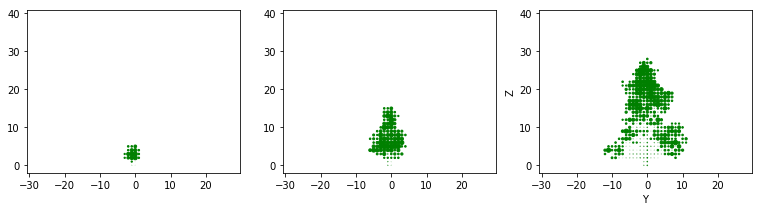

In [62]:
#plot_plan(dataM[90], s=[-2,2],area=20)
plot_plan_in_line(dataM, s=[-2,2], area=20,t=[20,50,90])

In [0]:
def plot_dev(dataM,t=50):
  plant1=slice_plant_mean3D(dataM,[-2,2])
  dev=np.gradient(plant1)
  print(dev[0].shape)
  y,z,b=flatten_plan0(dev[0][80,:,:])
  print(y.shape,z.shape, b.shape, len(get_color(b,"y","r","g")))

  fig = plt.figure()
  ax = Axes3D(fig)
  ax.scatter(y, z, b, c=get_color(b,"y","r","g"), marker='.')
  plt.title("U deriv respect to t tensorflow")
  ax.set_xlabel('y')
  ax.set_ylabel('Z')
  ax.set_zlabel('Ut')
  plt.show()

  y,z,b=flatten_plan0(dev[1][90])
  fig = plt.figure()
  ax = Axes3D(fig)
  ax.scatter(y, z, b, c=get_color(b,"b","r","g"), marker='.')
  plt.title("U deriv respect to y tensorflow")
  ax.set_xlabel('Y')
  ax.set_ylabel('Z')
  ax.set_zlabel('Uy')
  plt.show()

  y,z,b=flatten_plan0(dev[1][90])
  fig = plt.figure()
  ax = Axes3D(fig)
  ax.scatter(y, z, b, c=get_color(b,"g","r","b"), marker='.')
  plt.title("U deriv respect to z tensorflow")
  ax.set_xlabel('Y')
  ax.set_ylabel('Z')
  ax.set_zlabel('Uz')
  plt.show()

In [0]:
def plot_dev_2(dataM,t=50):
  plant1=slice_plant_mean3D(dataM,[-2,2])
  Utyz=np.gradient(plant1)
  Utyz=np.array(Utyz)
  
  Uyy=np.gradient(Utyz[1])[1]
  Uzz=np.gradient(Utyz[2])[2]
  #Uyy,Uzz=Uyy.flatten(), Uzz.flatten()
  
  y,z,b=flatten_plan0(Uyy[t])
  fig = plt.figure()
  ax = Axes3D(fig)
  ax.scatter(y, z, b, c=get_color(b,"b","r","g"), marker='.')
  plt.title("U 2nd deriv respect to y tensorflow")
  ax.set_xlabel('Y')
  ax.set_ylabel('Z')
  ax.set_zlabel('Uy')
  plt.show()

  y,z,b=flatten_plan0(Uzz[t])
  fig = plt.figure()
  ax = Axes3D(fig)
  ax.scatter(y, z, b, c=get_color(b,"g","r","b"), marker='.')
  plt.title("U 2nd deriv respect to z tensorflow")
  ax.set_xlabel('Y')
  ax.set_ylabel('Z')
  ax.set_zlabel('Uz')
  plt.show()

(100, 56, 40)


AttributeError: ignored

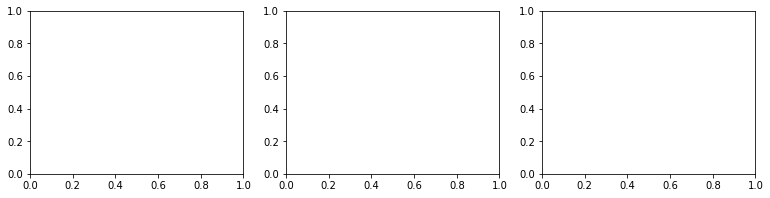

In [77]:
plot_dev(dataM,t=50)

# PLANT 1  Aubreville

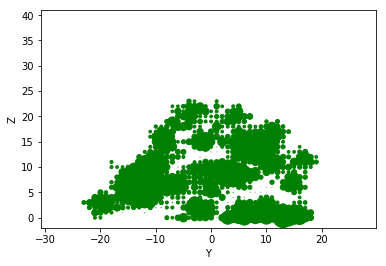

(100, 56, 40)
(2240,) (2240,) (2240,) 2240


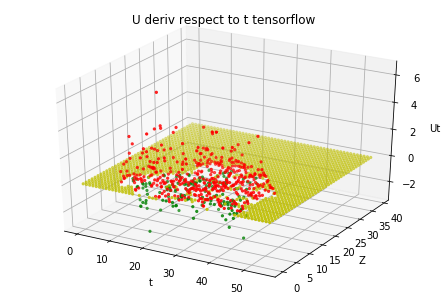

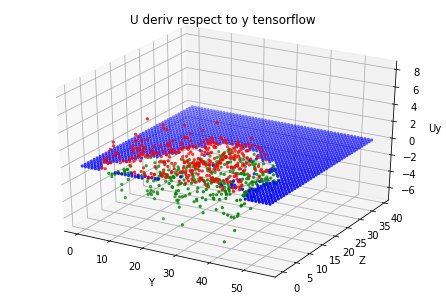

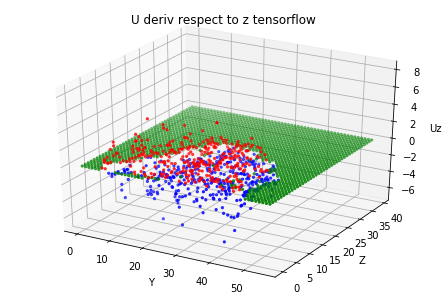

In [79]:
#dataM_AUb=get_plant_mean_of_race(get_data_plant_sliced_on_X(race=0))
dataM=dataM_AUb
plot_plan(dataM[90], s=[-2,2],area=20)
plot_dev(dataM,t=50)

##PART 2

In [0]:
T=np.linspace(0.1, 10, 100)
plant1=slice_plant_mean3D(dataM,[-2,2])
Utyz=np.gradient(plant1)
Utyz=np.array(Utyz)
print(Utyz.shape)
Uyzt_flatten=[]
u=plant1.flatten()
Ut,Uy,Uz=Utyz[0].flatten(),Utyz[1].flatten(),Utyz[2].flatten()

Uyy=np.gradient(Utyz[1])[1]
Uzz=np.gradient(Utyz[2])[2]
Uyy,Uzz=Uyy.flatten(), Uzz.flatten()
print(u.shape)

Ux_xx_trainFS=[[u[i],u[i]*u[i],u[i]*u[i]*u[i],
                u[i]*Uy[i],u[i]*Uz[i],
                Uy[i],Uz[i],Uy[i]*Uz[i],Uyy[i],Uzz[i]] for i in range(0,len(u))]

Ux_xx_train=[[Uyy[i]+Uzz[i]] for i in range(0,len(u))]
Ut_train=Ut
Ux_xx_train, Ux_xx_trainFS, Ut_train=np.array(Ux_xx_train), np.array(Ux_xx_trainFS), np.array(Ut_train)


(3, 100, 56, 40)
(224000,)


### Feature selection

In [0]:
def plot_variance(Ux_xx_trainFS):
  var_x=np.var(Ux_xx_trainFS, axis=0)
  names = ["U","U^2","U^3","U*Uy","U*Uz","Uy","Uz","Uy*Uz","Uyy","Uzz"]
  print(list(var_x))
  fig= plt.figure(figsize=(12,6))
  axes= fig.add_axes([0.1,0.1,0.8,0.8])
  axes.bar(np.arange(len(var_x))*2,np.fabs(var_x),tick_label=names)
  plt.show()

In [0]:
def RFE_plote(Ux_xx_trainFS,Ut_train):
  from sklearn.feature_selection import RFE
  from sklearn.linear_model import LinearRegression
  X_train,X_test,y_train,y_test=train_test_split(Ux_xx_trainFS, Ut_train, test_size=0.3, random_state=31)

  lr = LinearRegression()
  rfe = RFE(lr, n_features_to_select=1)
  rfe.fit(Ux_xx_trainFS, Ut_train)

  lr_train_score=rfe.score(X_train,y_train)
  lr_test_score=rfe.score(X_test,y_test)
  print ("LR training score:", lr_train_score)
  print ("LR test score: ", lr_test_score)
  print("*******************************************************")
  print ("Features sorted by rank:")
  print (sorted(zip(map(lambda x: round(x, 7), rfe.ranking_), names)))

  fig= plt.figure(figsize=(12,6))
  axes= fig.add_axes([0.1,0.1,0.8,0.8])
  axes.bar(np.arange(len(rfe.ranking_))*2,np.fabs(rfe.ranking_),tick_label=names)
  plt.show()

R-lasso

Use $\sum |W|$ to select feature

$ loss= \sum || y - W^T  X || ^2 + \alpha  \sum |W| $

In [0]:
def RLasso_plote(Ux_xx_trainFS,Ut_train):
  X_train,X_test,y_train,y_test=train_test_split(Ux_xx_trainFS, Ut_train, test_size=0.3, random_state=31)
  
  alphas=[1,0.00001,0.000001,0.00000001,0]
  error=[]
  for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10e3)
    lasso.fit(X_train,y_train)
    train_score=lasso.score(X_train,y_train)
    test_score=lasso.score(X_test,y_test)
    coeff_used = np.sum(lasso.coef_!=0)
    error.append([alpha,train_score,test_score])
    print("*********************alpha= ",alpha,"********************************")
    print ("training score :", train_score)
    print ("test score : ", test_score)
    print ("number of features used :", coeff_used)
    print(lasso.coef_)
    
    fig= plt.figure(figsize=(12,6))
    axes= fig.add_axes([0.1,0.1,0.8,0.8])
    axes.bar(np.arange(len(lasso.coef_))*2,np.fabs(lasso.coef_),tick_label=names)
    plt.show()
  error=np.array(error)

# comparing plants structure to selected features

*******************************************************************************
*******************************************************************************
*******************************************************************************
*********************************  Aubreville  ********************************
*******************************************************************************
*******************************************************************************


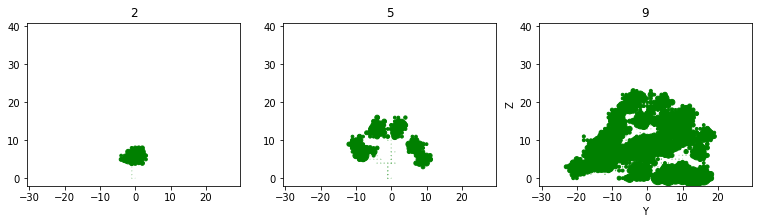

*************************************************************************
*******First Derivatives*********T= 50 ********************************
(100, 56, 40)
(2240,) (2240,) (2240,) 2240


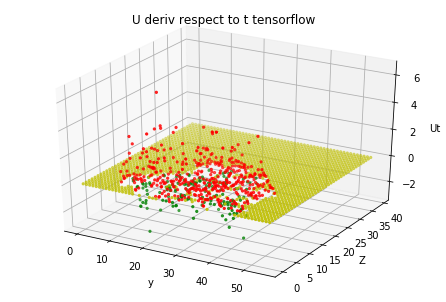

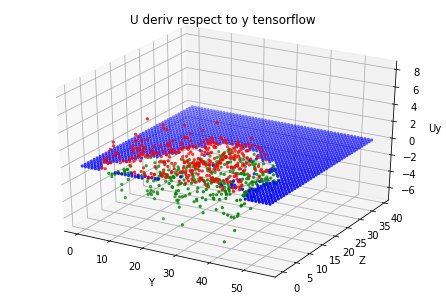

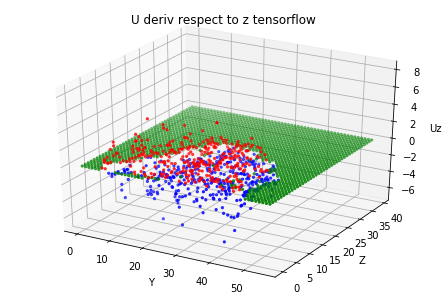

*************************************************************************
*******2nd Derivatives*********T= 50 ********************************


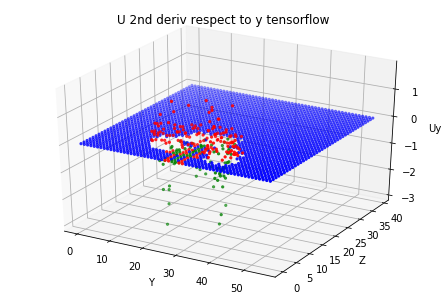

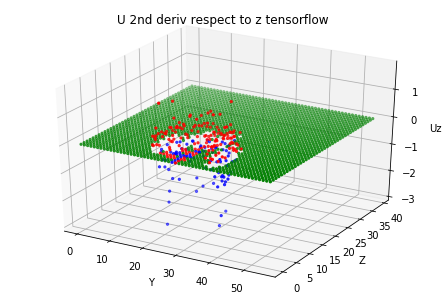

*************************************************************************
***************************Variace***************************************
[0.86267568820687, 58.94699715298513, 8942.622248983056, 3.415757509060549, 11.167384515953229, 0.17162752175186027, 0.26285444976972616, 0.6582655815223187, 0.10957084943187512, 0.1670957478102249]


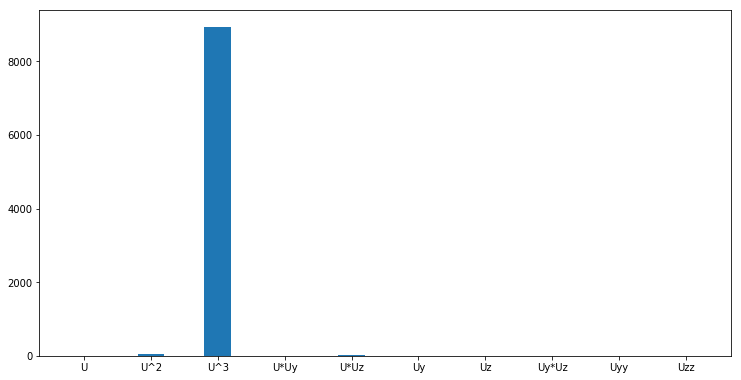

*************************************************************************
*************************** RFE  ***************************************
LR training score: 0.00013906394937102107
LR test score:  0.00016335285701019053
*******************************************************
Features sorted by rank:
[(1, 'Uz'), (2, 'Uzz'), (3, 'U'), (4, 'Uyy'), (5, 'Uy*Uz'), (6, 'U*Uz'), (7, 'U^2'), (8, 'Uy'), (9, 'U*Uy'), (10, 'U^3')]


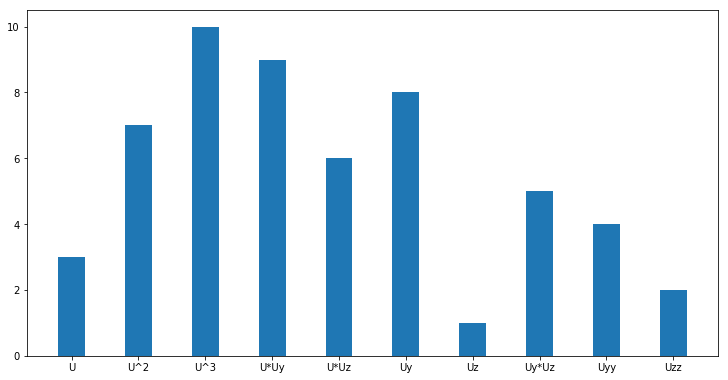

*************************************************************************
*************************** R- Lasso  ***************************************
*********************alpha=  1 ********************************
training score : 0.0
test score :  -3.6096608525992835e-05
number of features used : 0
[ 0.  0.  0.  0. -0. -0.  0.  0. -0.  0.]


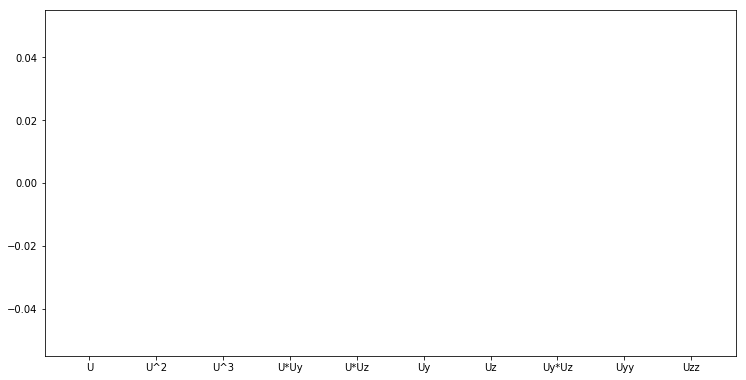

*********************alpha=  1e-05 ********************************
training score : 0.0008486501781703737
test score :  0.0005174326475576585
number of features used : 10
[ 4.70678458e-04 -5.48069583e-05  1.43627836e-06  4.22032333e-05
 -3.66535018e-05 -2.30052657e-04  5.65407552e-04  5.90010073e-05
 -3.02250857e-04  6.36888979e-04]


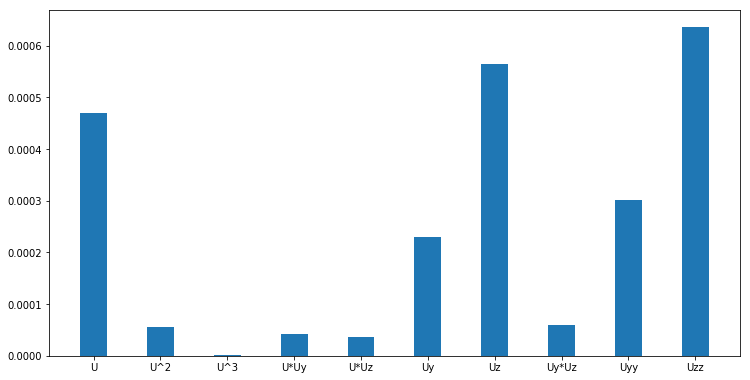

*********************alpha=  1e-06 ********************************
training score : 0.0008964280748253728
test score :  0.00045422293000207947
number of features used : 10
[ 6.26368729e-04 -9.21426192e-05  3.09062240e-06  6.98170914e-05
 -3.85822057e-05 -3.71475993e-04  6.34857326e-04  9.50248424e-05
 -4.92982389e-04  7.56453345e-04]


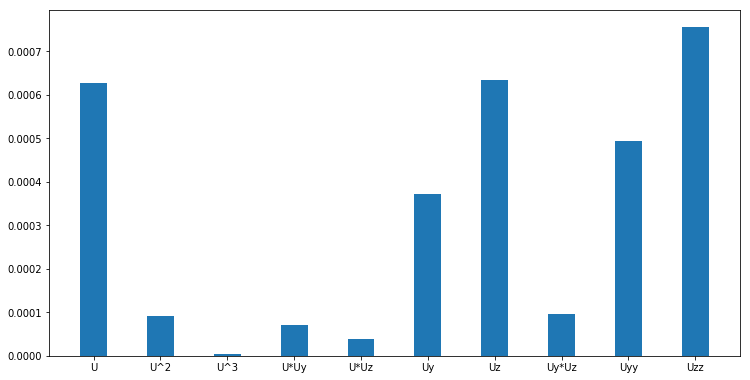

*********************alpha=  1e-08 ********************************
training score : 0.0008969106415189776
test score :  0.0004435751459663795
number of features used : 10
[ 6.43495471e-04 -9.62497773e-05  3.27261303e-06  7.28546049e-05
 -3.87943239e-05 -3.87032536e-04  6.42496699e-04  9.89875079e-05
 -5.13963000e-04  7.69605332e-04]


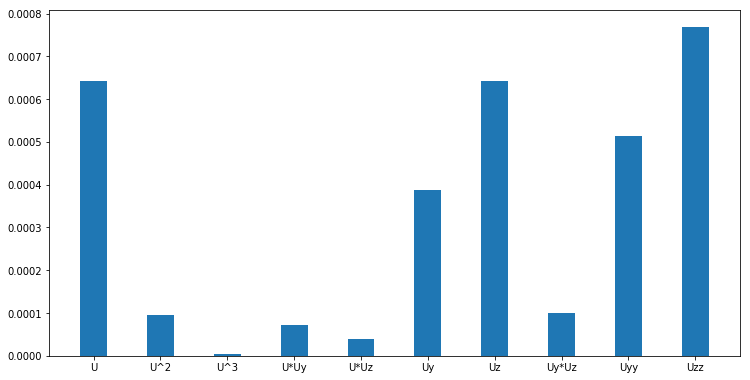

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.104750887740199, tolerance: 0.0028234825892648565
  positive)


*********************alpha=  0 ********************************
training score : 0.0008969106897800394
test score :  0.0004434638550228076
number of features used : 10
[ 6.43668463e-04 -9.62912622e-05  3.27445123e-06  7.28852869e-05
 -3.87964668e-05 -3.87189673e-04  6.42573865e-04  9.90275345e-05
 -5.14174924e-04  7.69738181e-04]


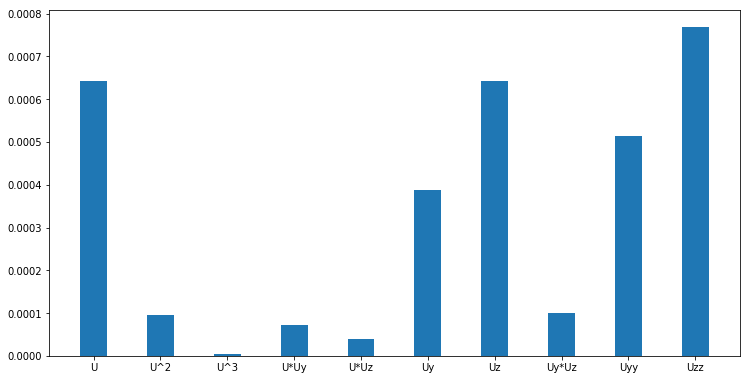

*******************************************************************************
*******************************************************************************
*******************************************************************************
*********************************  Prevost  ********************************
*******************************************************************************
*******************************************************************************


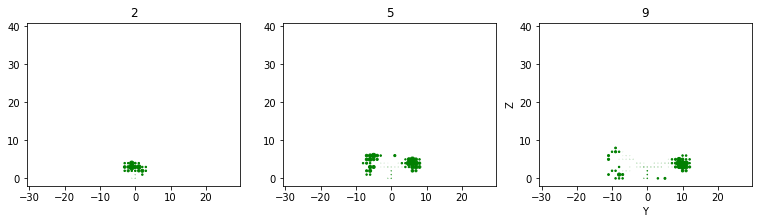

*************************************************************************
*******First Derivatives*********T= 50 ********************************
(100, 56, 40)
(2240,) (2240,) (2240,) 2240


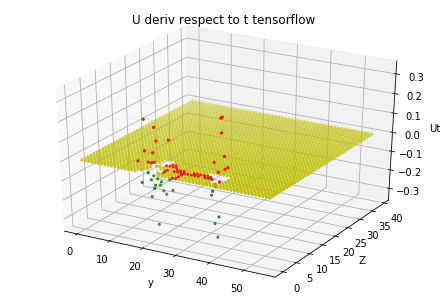

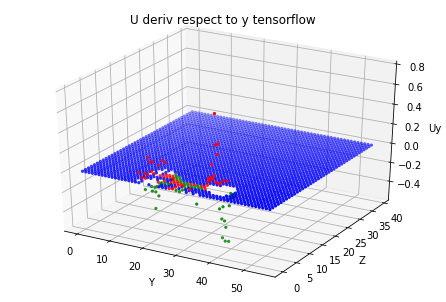

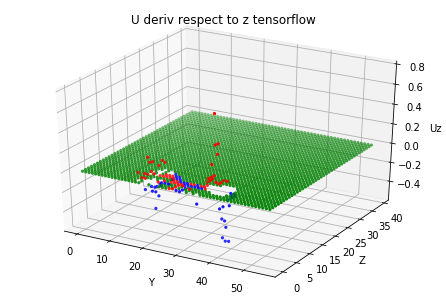

*************************************************************************
*******2nd Derivatives*********T= 50 ********************************


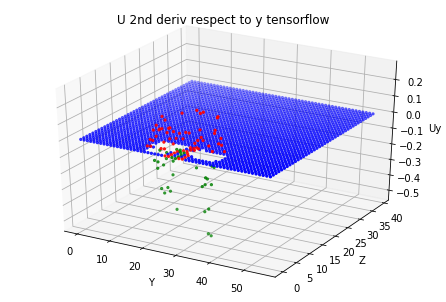

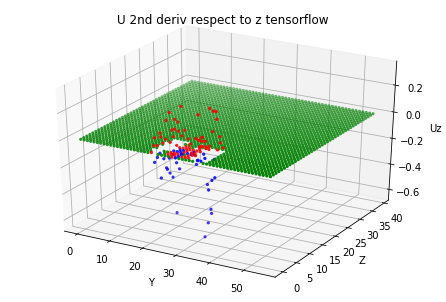

*************************************************************************
***************************Variace***************************************
[0.004032362204540677, 0.008118852289774605, 0.034943960913178966, 0.0006551110046784453, 0.00056661034890165, 0.0013712252559348703, 0.001725610932495031, 0.0001353397653473881, 0.0008851685125782886, 0.0012361945509657731]


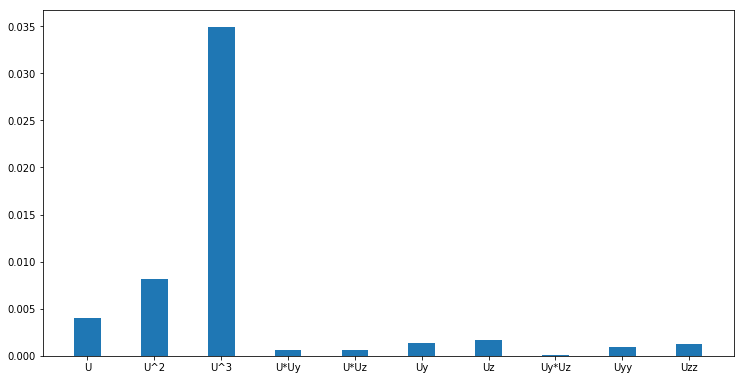

*************************************************************************
*************************** RFE  ***************************************
LR training score: 0.019831418097980724
LR test score:  0.08235638155969982
*******************************************************
Features sorted by rank:
[(1, 'U*Uy'), (2, 'Uz'), (3, 'Uzz'), (4, 'Uy'), (5, 'U*Uz'), (6, 'U'), (7, 'Uy*Uz'), (8, 'U^3'), (9, 'U^2'), (10, 'Uyy')]


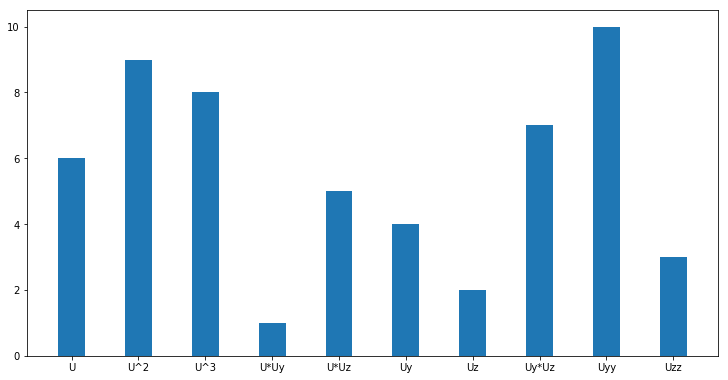

*************************************************************************
*************************** R- Lasso  ***************************************
*********************alpha=  1 ********************************
training score : 0.0
test score :  -3.6096608525992835e-05
number of features used : 0
[-0.  0.  0. -0. -0. -0. -0. -0.  0.  0.]


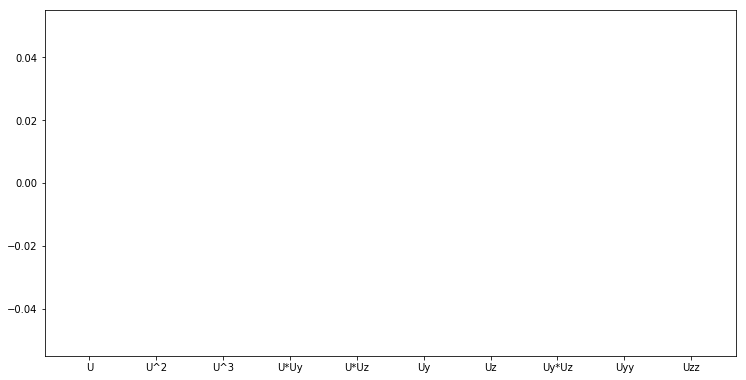

*********************alpha=  1e-05 ********************************
training score : 0.03674245753667982
test score :  0.05764930345906638
number of features used : 5
[-0.00031214 -0.          0.001652   -0.04393244 -0.         -0.01485556
 -0.03152029 -0.          0.          0.        ]


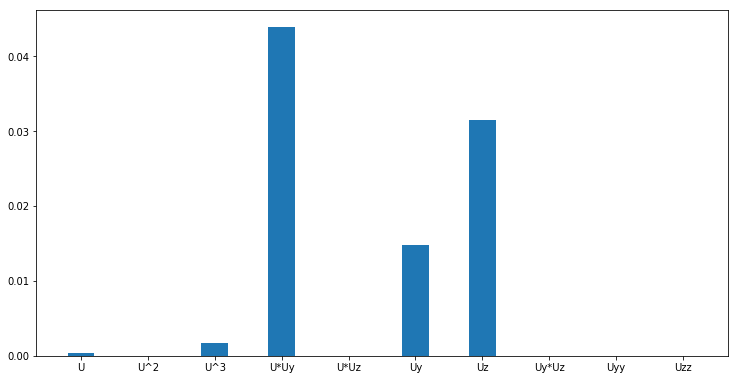

*********************alpha=  1e-06 ********************************
training score : 0.039264614595150404
test score :  0.059285896225055645
number of features used : 7
[ 0.00563599 -0.01978277  0.00963315 -0.05708083 -0.         -0.01515727
 -0.03575995 -0.01542934  0.         -0.        ]


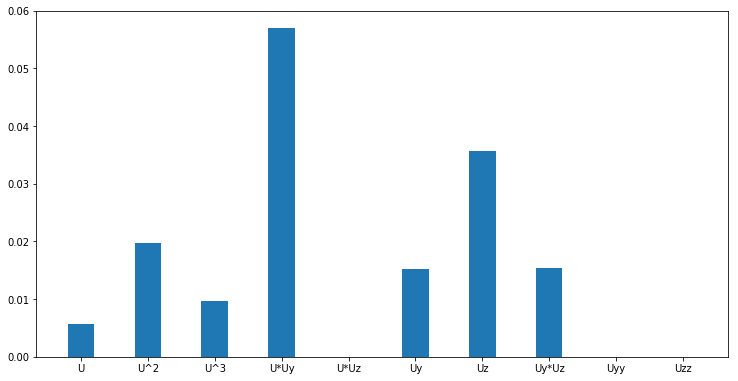

*********************alpha=  1e-08 ********************************
training score : 0.03950398170656455
test score :  0.05764246091242653
number of features used : 10
[ 0.01580566 -0.03658276  0.01495086 -0.0574064  -0.00185542 -0.01585843
 -0.03559649 -0.02305062  0.00054734 -0.00079091]


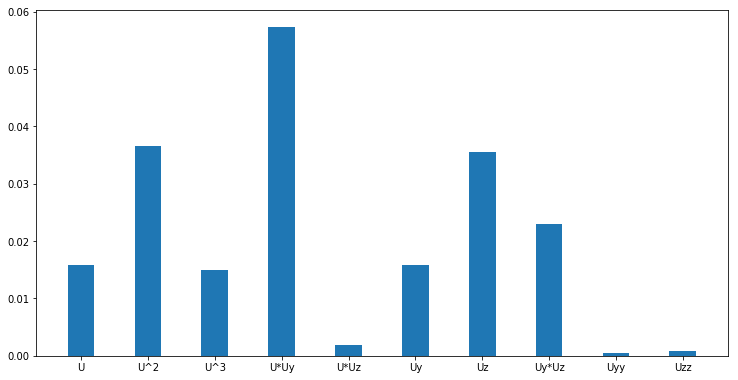

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.559718543930703, tolerance: 0.0028234825892648565
  positive)


*********************alpha=  0 ********************************
training score : 0.03950400859662406
test score :  0.05762382501097063
number of features used : 10
[ 0.01590832 -0.03675622  0.01500602 -0.05740756 -0.00189006 -0.01586592
 -0.03558894 -0.02312781  0.00056329 -0.00081197]


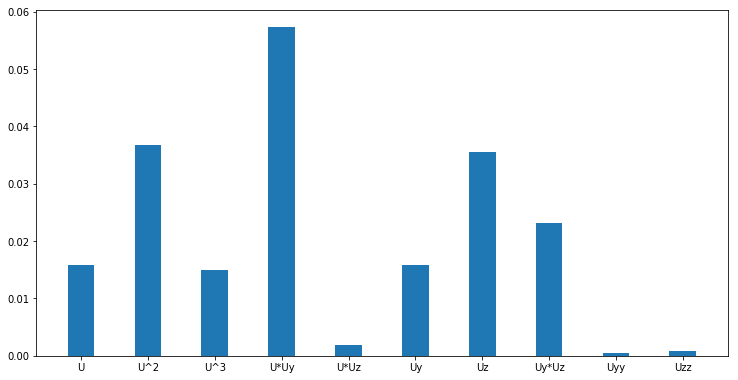

*******************************************************************************
*******************************************************************************
*******************************************************************************
*********************************  Massart  ********************************
*******************************************************************************
*******************************************************************************


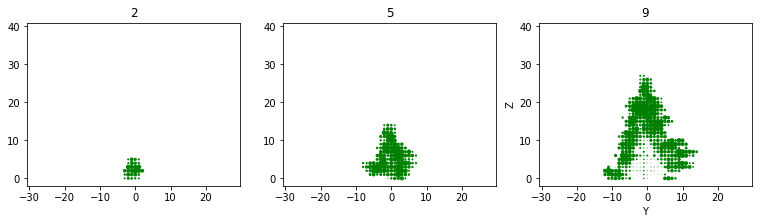

*************************************************************************
*******First Derivatives*********T= 50 ********************************
(100, 56, 40)
(2240,) (2240,) (2240,) 2240


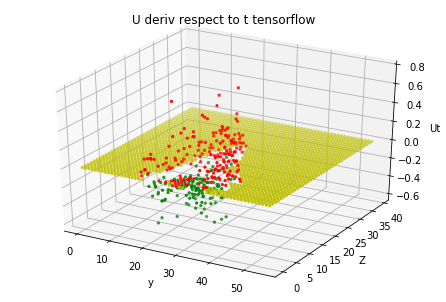

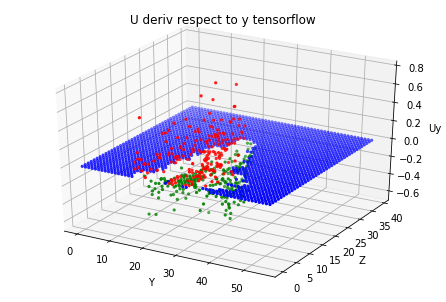

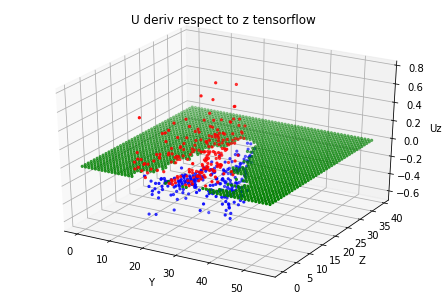

*************************************************************************
*******2nd Derivatives*********T= 50 ********************************


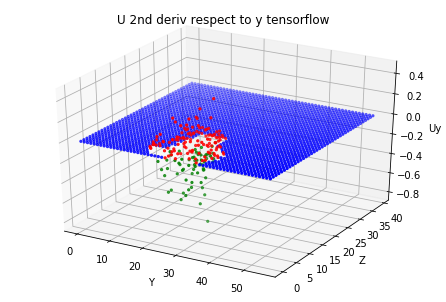

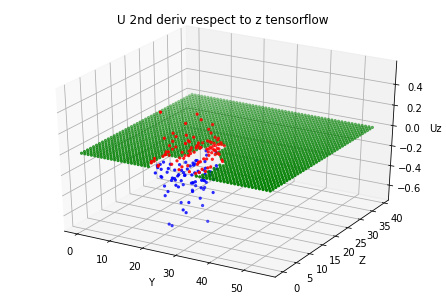

*************************************************************************
***************************Variace***************************************
[0.02485198624773565, 0.0325449162342937, 0.06914981479185185, 0.0021531351600777462, 0.0023358565993738816, 0.0047741701343798635, 0.004799202086709733, 0.00035781897550447915, 0.0027305819779894595, 0.003127151047823887]


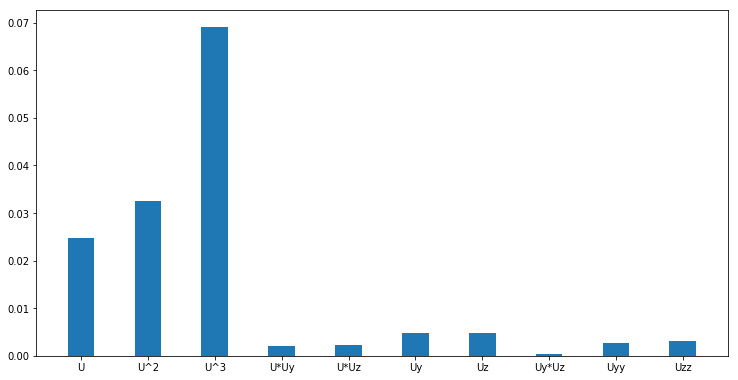

*************************************************************************
*************************** RFE  ***************************************
LR training score: 8.814631966524988e-05
LR test score:  -9.190129039104988e-06
*******************************************************
Features sorted by rank:
[(1, 'Uy*Uz'), (2, 'U^2'), (3, 'U^3'), (4, 'U*Uz'), (5, 'Uz'), (6, 'U*Uy'), (7, 'Uyy'), (8, 'Uy'), (9, 'U'), (10, 'Uzz')]


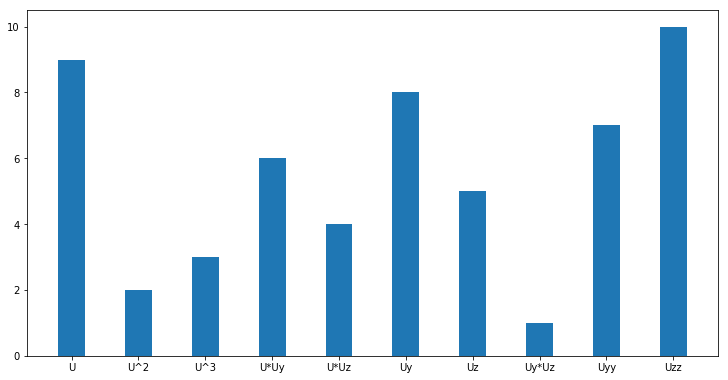

*************************************************************************
*************************** R- Lasso  ***************************************
*********************alpha=  1 ********************************
training score : 0.0
test score :  -3.6096608525992835e-05
number of features used : 0
[-0. -0. -0.  0.  0.  0. -0.  0.  0.  0.]


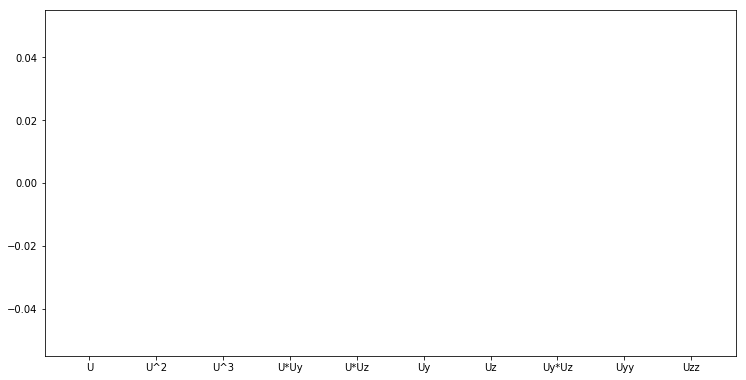

*********************alpha=  1e-05 ********************************
training score : 0.00220004061879997
test score :  0.0019435107043013211
number of features used : 2
[-0.00401543 -0.          0.00040263  0.          0.          0.
 -0.          0.          0.          0.        ]


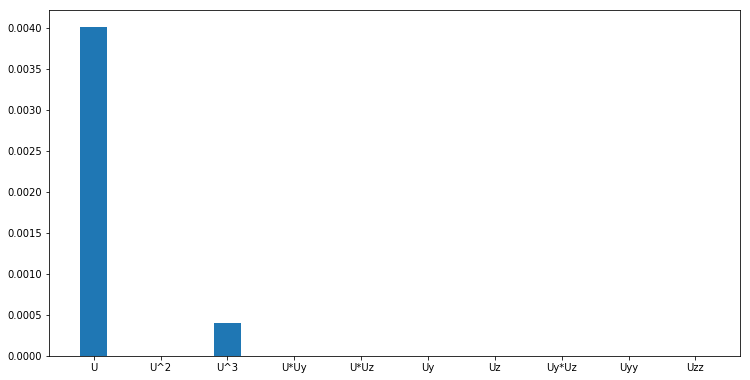

*********************alpha=  1e-06 ********************************
training score : 0.0030786210868471997
test score :  0.002857075291086697
number of features used : 9
[-0.00529083 -0.          0.00169239  0.00261633  0.00634166  0.00028426
 -0.00393314  0.00603057  0.00181726  0.00194448]


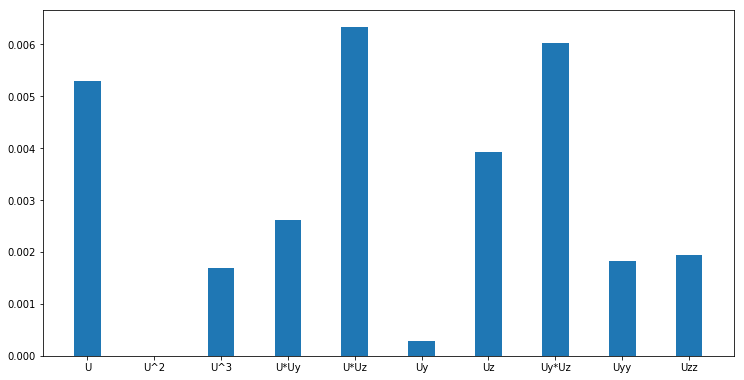

*********************alpha=  1e-08 ********************************
training score : 0.0031363316560768517
test score :  0.0031619265278950426
number of features used : 10
[-0.00373015 -0.00349554  0.00330993  0.00317958  0.00829283  0.00030349
 -0.00518992  0.00912118  0.00201972  0.00186604]


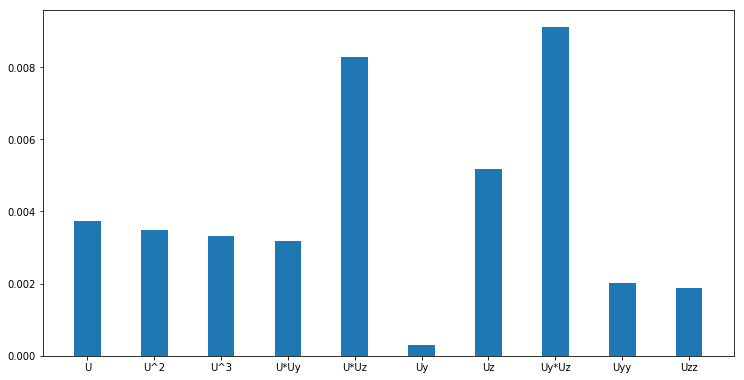

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.073135970104282, tolerance: 0.0028234825892648565
  positive)


*********************alpha=  0 ********************************
training score : 0.003136337825355051
test score :  0.0031647874386004915
number of features used : 10
[-0.00371232 -0.00353508  0.00332798  0.00318533  0.00831289  0.00030366
 -0.00520284  0.00915248  0.00202132  0.00186488]


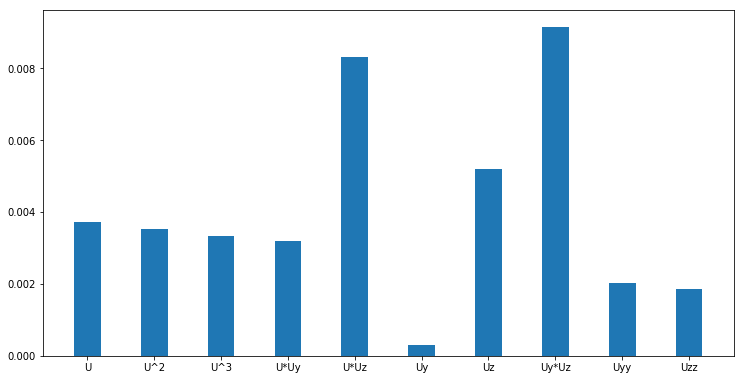

*******************************************************************************
*******************************************************************************
*******************************************************************************
*********************************  Rauh  ********************************
*******************************************************************************
*******************************************************************************


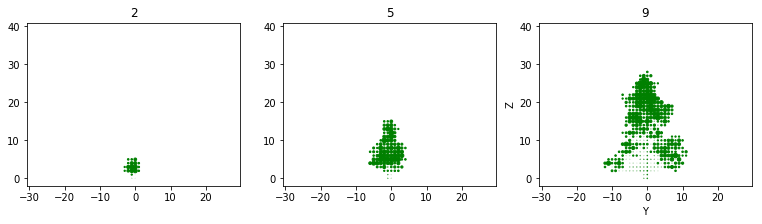

*************************************************************************
*******First Derivatives*********T= 50 ********************************
(100, 56, 40)
(2240,) (2240,) (2240,) 2240


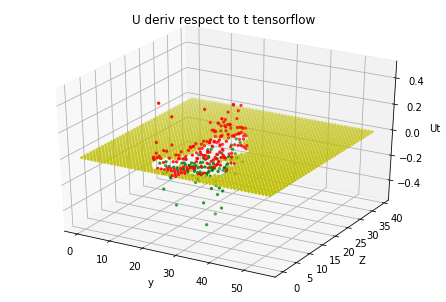

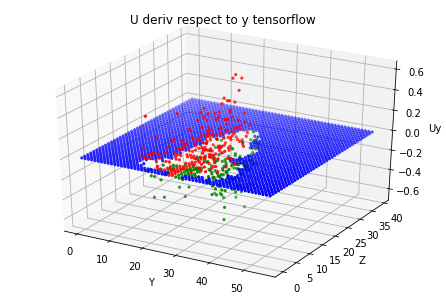

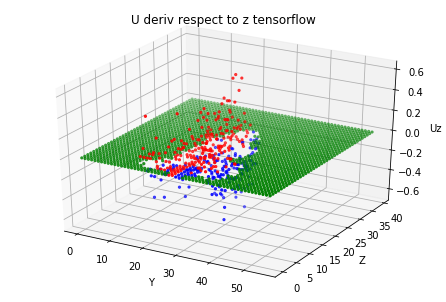

*************************************************************************
*******2nd Derivatives*********T= 50 ********************************


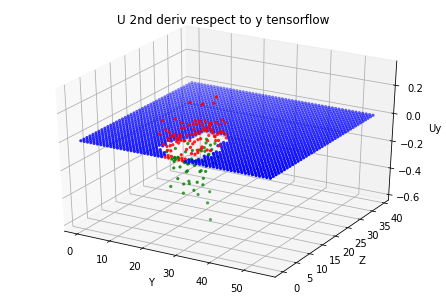

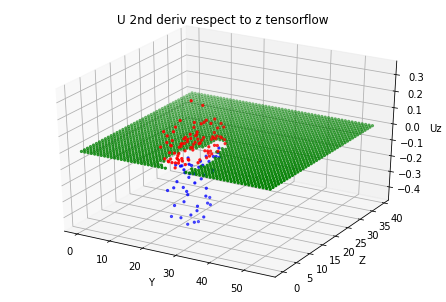

*************************************************************************
***************************Variace***************************************
[0.010926330562398516, 0.00833943542436607, 0.010664012692760853, 0.000601395594227763, 0.0005630004557228807, 0.0022604838343444965, 0.0020786366595455428, 8.374033262142797e-05, 0.0013154340113721162, 0.0013288032919428138]


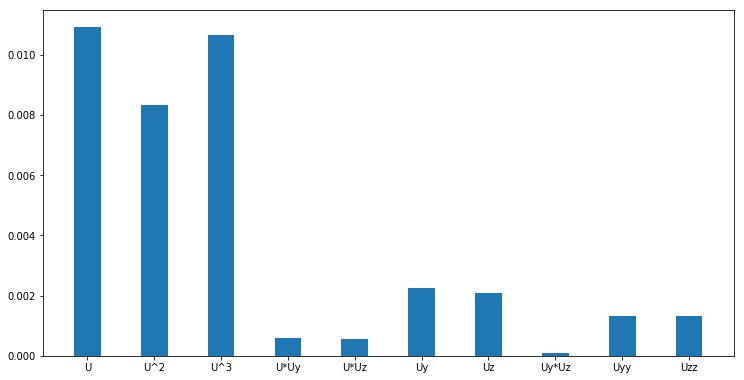

*************************************************************************
*************************** RFE  ***************************************
LR training score: 0.0016168990440552644
LR test score:  0.0011450688518285235
*******************************************************
Features sorted by rank:
[(1, 'Uyy'), (2, 'Uy*Uz'), (3, 'Uz'), (4, 'U*Uy'), (5, 'Uy'), (6, 'U*Uz'), (7, 'Uzz'), (8, 'U'), (9, 'U^3'), (10, 'U^2')]


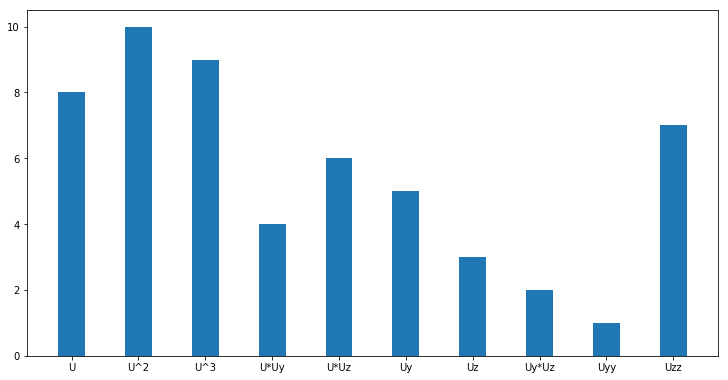

*************************************************************************
*************************** R- Lasso  ***************************************
*********************alpha=  1 ********************************
training score : 0.0
test score :  -3.6096608525992835e-05
number of features used : 0
[-0. -0. -0. -0. -0.  0. -0. -0.  0.  0.]


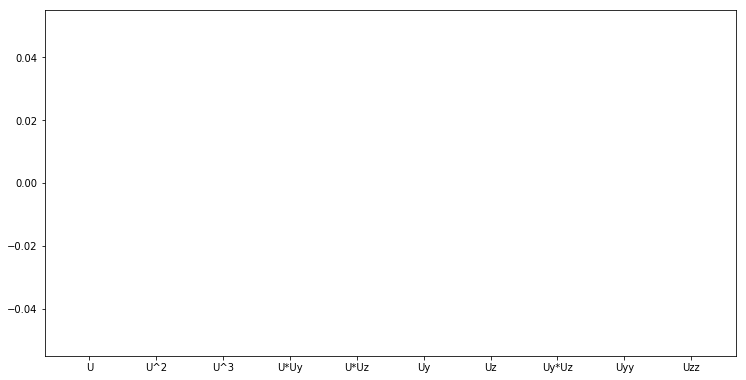

*********************alpha=  1e-05 ********************************
training score : 0.0022862616727379326
test score :  0.0021362543159195724
number of features used : 3
[-0.00426429 -0.         -0.         -0.         -0.          0.
 -0.00436146 -0.          0.00012489  0.        ]


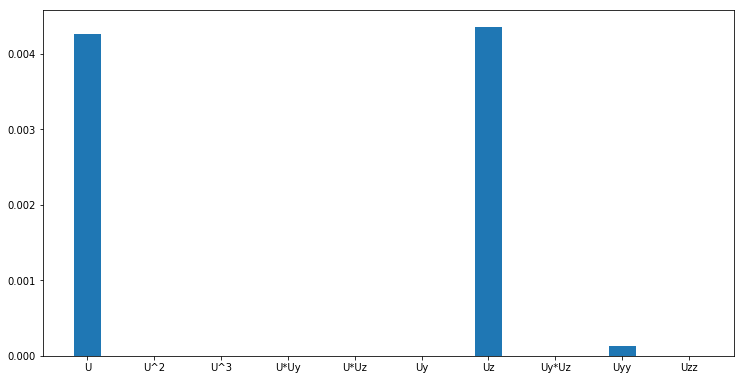

*********************alpha=  1e-06 ********************************
training score : 0.0034404315984447598
test score :  0.0033991950273518645
number of features used : 8
[-0.00342069  0.          0.00073118 -0.00783698  0.00306826  0.0044255
 -0.00986985 -0.          0.00704322  0.0044086 ]


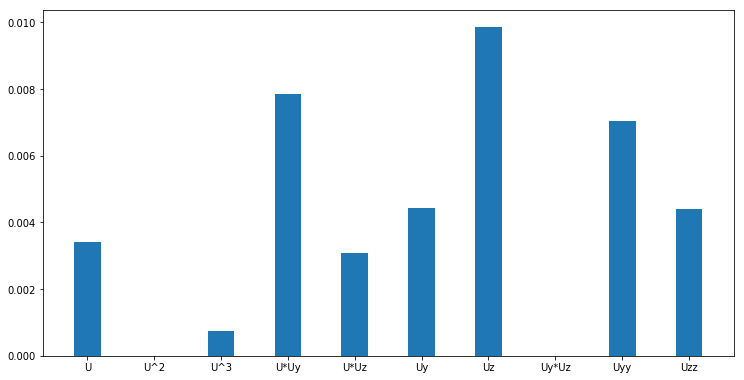

*********************alpha=  1e-08 ********************************
training score : 0.003554771370896992
test score :  0.0034985518121541936
number of features used : 10
[-0.0040713   0.00125188  0.00062234 -0.01324041  0.00900568  0.00686748
 -0.01272125 -0.0040029   0.00774518  0.00547715]


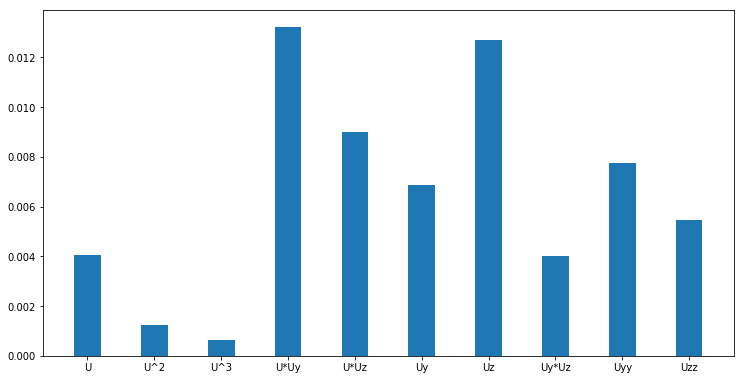

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.067228412190673, tolerance: 0.0028234825892648565
  positive)


*********************alpha=  0 ********************************
training score : 0.0035547967834945737
test score :  0.0034995637491033187
number of features used : 10
[-0.00412294  0.00138496  0.00055791 -0.01330016  0.00906869  0.00689083
 -0.01275171 -0.00412849  0.00775999  0.00549499]


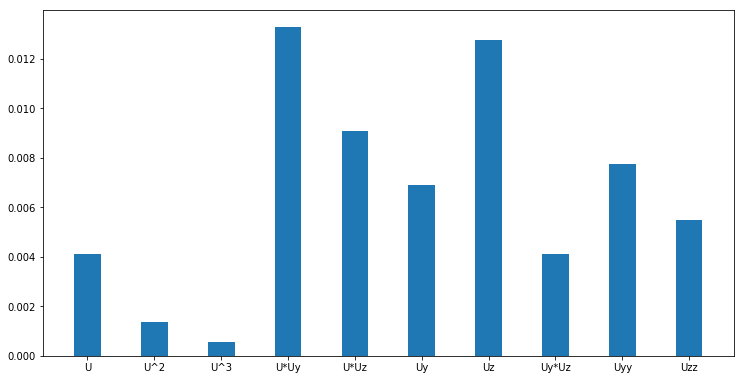

In [91]:
p_race=[0,7,5,8]
listeType=["Aubreville", "Corner", "Fagerlind", "Koriba", "Leeuwenberg", "Massart", "Nozeran", "Prevost", "Rauh", "Scarrone", "Troll"]
td=50
for race in p_race:
  print("*******************************************************************************")
  print("*******************************************************************************")
  print("*******************************************************************************")
  print("********************************* ", listeType[race] ," ********************************")
  print("*******************************************************************************")
  print("*******************************************************************************")
  dataM_Pre=get_plant_mean_of_race(get_data_plant_sliced_on_X(race=race))
  dataM=dataM_Pre
  plot_plan_in_line(dataM, s=[-2,2], area=20,t=[20,50,90])
  
  print("*************************************************************************")
  print("*******First Derivatives*********T=",td,"********************************")
  plot_dev(dataM,t=td)
  
  print("*************************************************************************")
  print("*******2nd Derivatives*********T=",td,"********************************")
  plot_dev_2(dataM,t=50)
  
  T=np.linspace(0.1, 10, 100)
  plant1=slice_plant_mean3D(dataM,[-2,2])
  Utyz=np.gradient(plant1)
  Utyz=np.array(Utyz)
  Uyzt_flatten=[]
  u=plant1.flatten()
  Ut,Uy,Uz=Utyz[0].flatten(),Utyz[1].flatten(),Utyz[2].flatten()

  Uyy=np.gradient(Utyz[1])[1]
  Uzz=np.gradient(Utyz[2])[2]
  Uyy,Uzz=Uyy.flatten(), Uzz.flatten()
  
  Ux_xx_trainFS=[[u[i],u[i]*u[i],u[i]*u[i]*u[i],
                u[i]*Uy[i],u[i]*Uz[i],
                Uy[i],Uz[i],Uy[i]*Uz[i],Uyy[i],Uzz[i]] for i in range(0,len(u))]

  Ux_xx_train=[[Uyy[i]+Uzz[i]] for i in range(0,len(u))]

  t_train=Ut
  Ux_xx_train, Ux_xx_trainFS, Ut_train=np.array(Ux_xx_train), np.array(Ux_xx_trainFS), np.array(Ut_train)
  
  print("*************************************************************************")
  print("***************************Variace***************************************")
  plot_variance(Ux_xx_trainFS)
  
  print("*************************************************************************")
  print("*************************** RFE  ***************************************")
  RFE_plote(Ux_xx_trainFS,Ut_train)
  
  print("*************************************************************************")
  print("*************************** R- Lasso  ***************************************")
  RLasso_plote(Ux_xx_trainFS,Ut_train)
  
  
  


#Train with seleccted features  Massart

In [92]:
dataM=get_plant_mean_of_race(get_data_plant_sliced_on_X(race=race))
plant1=slice_plant_mean3D(dataM,[-2,2])
Utyz=np.gradient(plant1)
Utyz=np.array(Utyz)
print(Utyz.shape)
Uyzt_flatten=[]
u=plant1.flatten()
Ut,Uy,Uz=Utyz[0].flatten(),Utyz[1].flatten(),Utyz[2].flatten()

Uyy=np.gradient(Utyz[1])[1]
Uzz=np.gradient(Utyz[2])[2]
Uyy,Uzz=Uyy.flatten(), Uzz.flatten()
print(u.shape)

Ux_xx_trainFS=[[u[i],u[i]*u[i],u[i]*u[i]*u[i],
                u[i]*Uy[i],u[i]*Uz[i],
                Uy[i],Uz[i],Uy[i]*Uz[i],Uyy[i],Uzz[i]] for i in range(0,len(u))]

Ux_xx_train=[[Uyy[i]+Uzz[i]] for i in range(0,len(u))]
Ut_train=Ut
Ux_xx_train, Ux_xx_trainFS, Ut_train=np.array(Ux_xx_train), np.array(Ux_xx_trainFS), np.array(Ut_train)


(3, 100, 56, 40)
(224000,)


### with variance $U, U^2, U^3$ 

In [120]:
Berg_Nystrom_skl_model_2_No_Hidden_m_2 = MLPRegressor(solver='lbfgs',alpha=1e-7, tol=1e-51, hidden_layer_sizes=(), random_state=1, max_iter=10)
Ux_xx_train_s=[[u[0],u[1],u[2]] for u in Ux_xx_trainFS]
Berg_Nystrom_skl_model_2_No_Hidden_m_2.fit(Ux_xx_train_s, Ut_train)
print("Weights:", Berg_Nystrom_skl_model_2_No_Hidden_m_2.coefs_)
print("error : ", Berg_Nystrom_skl_model_2_No_Hidden_m_2.score(Ux_xx_train_s, Ut_train))

Weights: [array([[-0.08678349],
       [ 0.19159954],
       [-0.11192181]])]
error :  -0.03237446652440146


### with RFE : $U_{zz}, U, U_{y}$

In [117]:
Berg_Nystrom_skl_model_2_No_Hidden_m_2 = MLPRegressor(solver='lbfgs',alpha=1e-7, tol=1e-51, hidden_layer_sizes=(), random_state=1, max_iter=1000)
Ux_xx_train_s=[[u[1],u[6],u[9]] for u in Ux_xx_trainFS]
Berg_Nystrom_skl_model_2_No_Hidden_m_2.fit(Ux_xx_train_s, Ut_train)
print("Weights:", Berg_Nystrom_skl_model_2_No_Hidden_m_2.coefs_)
print("error : ", Berg_Nystrom_skl_model_2_No_Hidden_m_2.score(Ux_xx_train_s, Ut_train))

Weights: [array([[ 0.00713284],
       [-0.06000528],
       [-0.00228244]])]
error :  0.018911350150824235


### with R-lasso  $U_y*U_z, U \times U_z, U_{y} \times U_{z}$

In [118]:
Berg_Nystrom_skl_model_2_No_Hidden_m_2 = MLPRegressor(solver='lbfgs',alpha=1e-7, tol=1e-51, hidden_layer_sizes=(), random_state=1, max_iter=1000)
Ux_xx_train_s=[[u[7],u[4],u[6]] for u in Ux_xx_trainFS]
Berg_Nystrom_skl_model_2_No_Hidden_m_2.fit(Ux_xx_train_s, Ut_train)
print("Weights:", Berg_Nystrom_skl_model_2_No_Hidden_m_2.coefs_)
print("error : ", Berg_Nystrom_skl_model_2_No_Hidden_m_2.score(Ux_xx_train_s, Ut_train))

Weights: [array([[ 0.00651334],
       [-0.04167198],
       [-0.04320943]])]
error :  0.018661891794910734


### train and view coef

In [108]:
U_u_train=[[u[i], u[i]**2, u[i]**3] for i in range(0,len(u))]
Berg_Nystrom_skl_model_2_No_Hidden_u3 = MLPRegressor(solver='lbfgs',alpha=1e-7, tol=1e-51, hidden_layer_sizes=(), random_state=1, max_iter=1000)
U_u_train=np.array(U_u_train).reshape(-1,3)
Berg_Nystrom_skl_model_2_No_Hidden_u3.fit(Ux_xx_trainFS, Ut_train)
print("Weights:", Berg_Nystrom_skl_model_2_No_Hidden_u3.coefs_)

print("error : ", Berg_Nystrom_skl_model_2_No_Hidden_u3.score(Ux_xx_trainFS, Ut_train))


Weights: [array([[ 0.0492366 ],
       [-0.09129117],
       [ 0.04110697],
       [ 0.00833792],
       [-0.04361879],
       [-0.00841878],
       [-0.04500659],
       [ 0.01907671],
       [-0.00752757],
       [-0.00532097]])]
error :  0.023683625755075433
